In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV  
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from pprint import pprint
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
# Leer data en formato csv
data = pd.read_csv("data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Columns: 217 entries, Unnamed: 0 to mtq_dif_chronotype
dtypes: float64(196), int64(21)
memory usage: 1.4 MB


In [3]:
# PSQI_TOTAL es la variable que se trata de predecir
y=data['PSQI_TOTAL']
X = data.drop('PSQI_TOTAL', axis=1)

In [4]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=132, shuffle=True)

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

In [6]:
# Probar modelo de regresion Random forest

In [7]:
# Random forest regressor
rf = RandomForestRegressor(n_estimators= 150, min_samples_split= 10,min_impurity_decrease=0.01, max_features= 'auto', max_depth= 30,bootstrap= True)
rf.fit(X_train_scaled, y_train)
y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)

rf_MSE_train= mean_squared_error(y_train, y_pred_train)
rf_MSE_test=mean_squared_error(y_test, y_pred_test)
rf_R2_train=r2_score(y_train, y_pred_train)
rf_R2_test= r2_score(y_test, y_pred_test)

In [ ]:
#Optimizar parámetros con RandomizedSearchCV

In [12]:
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 30,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.01,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [13]:
param_grid = { 
    "bootstrap": [True, False],
    "max_depth": [10, 25, 50, 100],
    "max_features": ["auto", "sqrt", "log2"],
    "min_impurity_decrease": [.1, 0.01, 0.],
    "min_samples_split": [2, 4, 8],
    "n_estimators": [10, 20, 50,100],
}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions = param_grid, n_iter=10, cv = 3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(max_depth=30,
                                                   min_impurity_decrease=0.01,
                                                   min_samples_split=10,
                                                   n_estimators=150),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 25, 50, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_impurity_decrease': [0.1, 0.01,
                                                                  0.0],
                                        'min_samples_split': [2, 4, 8],
                                        'n_estimators': [10, 20, 50, 100]},
                   random_state=42, verbose=2)

In [14]:
print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", rf_random.best_estimator_)
print("\n The best score across ALL searched params:\n", rf_random.best_score_)
print("\n The best parameters across ALL searched params:\n", rf_random.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(max_depth=10, min_impurity_decrease=0.01,
                      min_samples_split=8)

 The best score across ALL searched params:
 0.740041908513577

 The best parameters across ALL searched params:
 {'n_estimators': 100, 'min_samples_split': 8, 'min_impurity_decrease': 0.01, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}


In [15]:
y_pred_train = rf_random.predict(X_train_scaled)
y_pred_test = rf_random.predict(X_test)

print("MSE Train", mean_squared_error(y_train, y_pred_train))
print("MSE Test", mean_squared_error(y_test, y_pred_test))
print("R2 Train", r2_score(y_train, y_pred_train))
print("R2 Test", r2_score(y_test, y_pred_test))

MSE Train 0.6275500110992642
MSE Test 13.267736154245702
R2 Train 0.9388190620020095
R2 Test -0.3371251547639953


In [ ]:
# La optimización de parámetros no mejoró la predicción del Random forest.
# Probemos ahora distintos regesores

In [8]:
#Logistic regressor
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=52,solver='liblinear', max_iter=100)
lr.fit(X_train_scaled, y_train)
y_pred_train_lr = lr.predict(X_train_scaled)
y_pred_test_lr = lr.predict(X_test_scaled)

lr_MSE_train=mean_squared_error(y_train, y_pred_train_lr)
lr_MSE_test= mean_squared_error(y_test, y_pred_test_lr)
lr_R2_train=r2_score(y_train, y_pred_train_lr)
lr_R2_test=r2_score(y_test, y_pred_test_lr)

In [9]:
# GradientBoosting regressor
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train_scaled, y_train)
y_pred_train_gb = reg.predict(X_train_scaled)
y_pred_test_gb = reg.predict(X_test_scaled)

gb_MSE_train=mean_squared_error(y_train, y_pred_train_gb)
gb_MSE_test=mean_squared_error(y_test, y_pred_test_gb)
gb_R2_train=r2_score(y_train, y_pred_train_gb)
gb_R2_test=r2_score(y_test, y_pred_test_gb)


In [10]:
# HistGradientBoosting regressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

est = HistGradientBoostingRegressor().fit(X_train_scaled, y_train)
y_pred_train_hg = est.predict(X_train_scaled)
y_pred_test_hg = est.predict(X_test_scaled)

hg_MSE_train= mean_squared_error(y_train, y_pred_train_hg)
hg_MSE_test=mean_squared_error(y_test, y_pred_test_hg)
hg_R2_train=r2_score(y_train, y_pred_train_hg)
hg_R2_test=r2_score(y_test, y_pred_test_hg)

In [11]:
# Resultados
print('Rainforest regressor')
print('MSE train', rf_MSE_train)
print('MSE test', rf_MSE_test)
print('R2 train',rf_R2_train)
print('R2 test',rf_R2_test)
print('-------------------------')
print()
print('Logistic regressor')
print('MSE train', lr_MSE_train)
print('MSE test', lr_MSE_test)
print('R2 train',lr_R2_train)
print('R2 test',lr_R2_test)
print('-------------------------')
print()
print('GradientBoosting regressor')
print('MSE train', gb_MSE_train)
print('MSE test', gb_MSE_test)
print('R2 train',gb_R2_train)
print('R2 test',gb_R2_test)
print('-------------------------')
print()
print('HistGradientBoosting regressor')
print('MSE train', hg_MSE_train)
print('MSE test', hg_MSE_test)
print('R2 train',hg_R2_train)
print('R2 test',hg_R2_test)


Rainforest regressor
MSE train 0.6706616714659361
MSE test 1.580686830952565
R2 train 0.9346160315291655
R2 test 0.8406980588926989
-------------------------

Logistic regressor
MSE train 0.08345752608047691
MSE test 8.595238095238095
R2 train 0.991863581167577
R2 test 0.13377015229151423
-------------------------

GradientBoosting regressor
MSE train 0.2880152228233982
MSE test 0.961687226162907
R2 train 0.9719208968554245
R2 test 0.9030809652703151
-------------------------

HistGradientBoosting regressor
MSE train 0.12996508810308258
MSE test 1.0772176789470858
R2 train 0.9873294783578924
R2 test 0.8914377826833924


In [39]:
#df para representar gráficamente MSE y R2
df_MSE = pd.DataFrame({'Regressor': ['Rainforest', 'Logistic', 'GradientBoosting', 'HistGradientBoosting'],
                   'Values': [rf_MSE_test,lr_MSE_test,gb_MSE_test,hg_MSE_test]})

df_R2 = pd.DataFrame({'Regressor': ['Rainforest', 'Logistic', 'GradientBoosting', 'HistGradientBoosting'],
                   'Values': [rf_R2_test,lr_R2_test,gb_R2_test,hg_R2_test]})


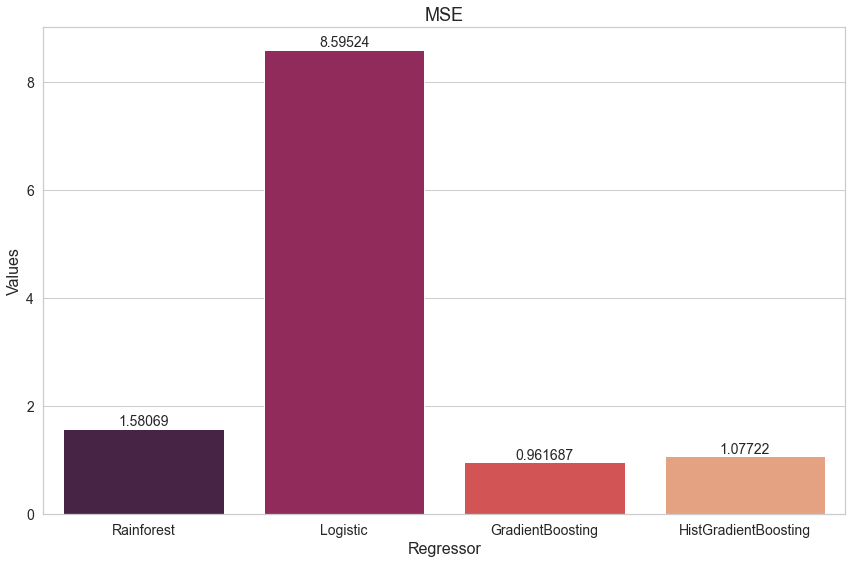

<Figure size 432x288 with 0 Axes>

In [85]:
#Bar plot para MSE
fig, axs = plt.subplots(ncols=1,figsize=(12,8))
sns.barplot(x='Regressor', y='Values', data=df_MSE, palette='rocket',ax=axs)
plt.title('MSE',fontsize=18)
axs.xaxis.label.set_size(16)
axs.yaxis.label.set_size(16)
plt.setp(axs.get_xticklabels(), fontsize=14)
plt.setp(axs.get_yticklabels(), fontsize=14)
axs.bar_label(axs.containers[0], fontsize=14)
plt.tight_layout()
plt.show()
plt.gcf().clear()


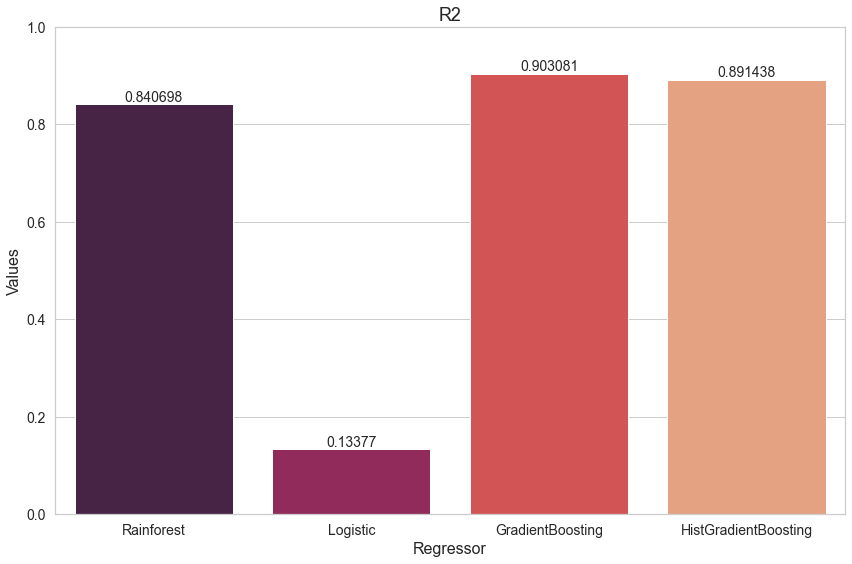

<Figure size 432x288 with 0 Axes>

In [86]:
#Bar plot para R2
fig, axs = plt.subplots(ncols=1,figsize=(12,8))
sns.barplot(x='Regressor', y='Values', data=df_R2, palette='rocket',ax=axs)
plt.title('R2',fontsize=18)
axs.xaxis.label.set_size(16)
axs.yaxis.label.set_size(16)
plt.setp(axs.get_xticklabels(), fontsize=14)
plt.setp(axs.get_yticklabels(), fontsize=14)
axs.set_ylim(0,1.0)
axs.bar_label(axs.containers[0], fontsize=14)
plt.tight_layout()
plt.show()
plt.gcf().clear()

Text(0.5, 1.0, 'Predicted PSQI (%)')

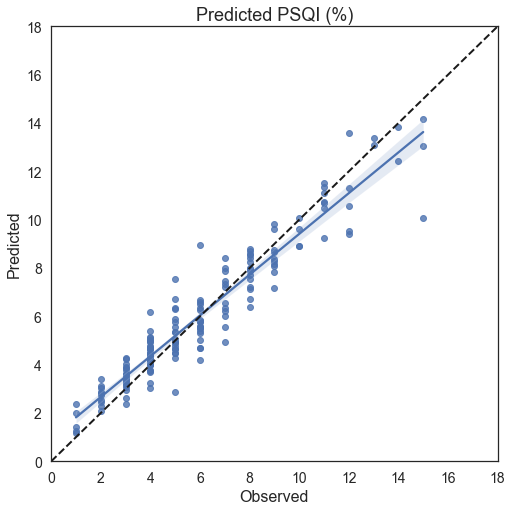

In [77]:
#Predicted Vs Observed for best regressor
df_gb_pred = pd.DataFrame({'Observed': y_test, 'Predicted': y_pred_test_gb})
df_gb_pred.describe()
plt.figure(figsize=(8, 8))
ax = sns.regplot(x="Observed", y="Predicted", data=df_gb_pred)
ax.set_ylim(0,18)
ax.set_xlim(0,18)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.plot([0, 18], [0, 18], 'k--', lw=2)
plt.title('Predicted PSQI (%)',fontsize=18)

In [81]:
from sklearn.decomposition import PCA
import numpy as np

pca_test = PCA(n_components=216)
#pca_test.fit(X_train)
pca_test.fit(X_train_scaled)
pca_df = pd.DataFrame()
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
rslt_df = pca_df[pca_df['Cumulative Variance Ratio'] > 0.95]
rslt_df

,Cumulative Variance Ratio,Explained Variance Ratio
137,0.950975,1.300825e-03
138,0.952258,1.283213e-03
139,0.953537,1.278716e-03
140,0.954788,1.251294e-03
141,0.956034,1.245626e-03
...,...,...
211,0.999765,1.419122e-04
212,0.999885,1.197378e-04
213,1.000000,1.149063e-04
214,1.000000,3.300961e-17


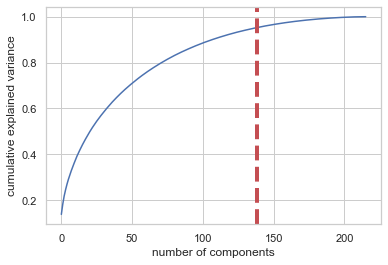

None

In [82]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=138, ymin=0, ymax=1)
display(plt.show())

In [83]:
pca = PCA(n_components=138)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

#regr = RandomForestRegressor(random_state=0)
#regr = RandomForestRegressor(n_estimators= 150, min_samples_split= 10, min_impurity_decrease=0.01, max_features= 'auto', max_depth= 30, bootstrap= True)
regr = GradientBoostingRegressor(random_state=0)
regr.fit(X_train_scaled_pca, y_train)
y_pred_train = regr.predict(X_train_scaled_pca)
y_pred_test = regr.predict(X_test_scaled_pca)

print("MSE Train", mean_squared_error(y_train, y_pred_train))
print("MSE Test", mean_squared_error(y_test, y_pred_test))
print("R2 Train", r2_score(y_train, y_pred_train))
print("R2 Test", r2_score(y_test, y_pred_test))

MSE Train 0.49541157514184864
MSE Test 4.26028893133358
R2 Train 0.9517014670924037
R2 Test 0.5706472128761888
